## Focus on Secretory cells

Focus on the non-integrated dataset

In [1]:
# Import useful modules

import numpy as np
import pandas as pd
import scanpy as sc
import os
#import igraph
import matplotlib.pyplot as plt
import seaborn

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=90)

scanpy==1.4+39.gc70f24b anndata==0.6.18 numpy==1.16.2 scipy==1.2.1 pandas==0.24.1 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 


In [2]:
# Load the integrated and annotated dataset
adata_ann = sc.read_h5ad('/Data/Annotated_dataset_v1.h5ad')

# Load non-integrated & pre-processed dataset
adata_raw = sc.read_h5ad('/Data/PreProcessed_preliminary_dataset.h5ad')

In [3]:
# Transfer annotation onto a non-data integrated anndata object.
adata = adata_raw[adata_ann.obs.index.tolist(), ]
adata.obs['cell_type'] = adata_ann.obs['cell_type']


In [4]:
secretory_cell_bool = []

for x in adata.obs['cell_type']:
    secretory_cell_bool = secretory_cell_bool + [x in ['Secretory', 'Secretory N']]


In [5]:
list_of_cell_names = adata.obs.loc[secretory_cell_bool, :].index.tolist()
adata = adata[list_of_cell_names, ]
adata.shape

(13980, 32568)

In [6]:
# Remove unwanted genes (mitochondrial genes)
genes_names = adata.var.index.tolist()
keep_genes = [i for i in genes_names if not i.startswith('MT-')]
adata = adata[:,keep_genes]

In [7]:
adata.shape

(13980, 32555)

In [8]:
sc.pp.filter_genes(adata, min_cells=100)
adata.X.shape

filtered out 18281 genes that are detected in less than 100 cells


(13980, 14274)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


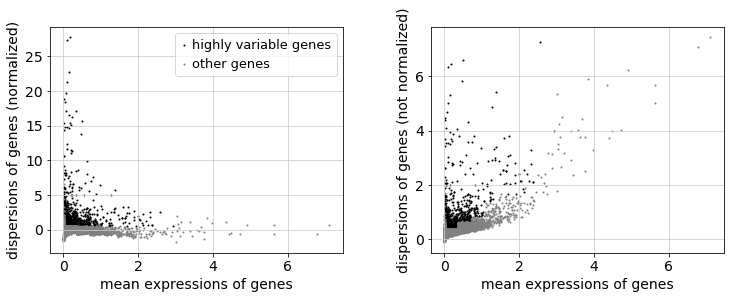

In [9]:
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [10]:
np.sum(adata.var['highly_variable'])

1243

In [11]:
sc.pp.scale(adata, max_value=10)

In [12]:
sc.tl.pca(adata, svd_solver='arpack')

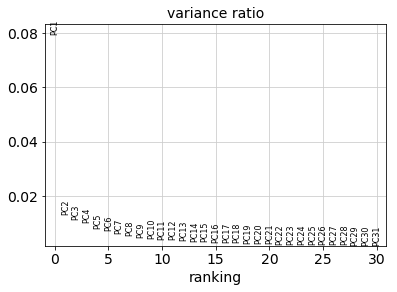

In [13]:
sc.pl.pca_variance_ratio(adata, log = False)

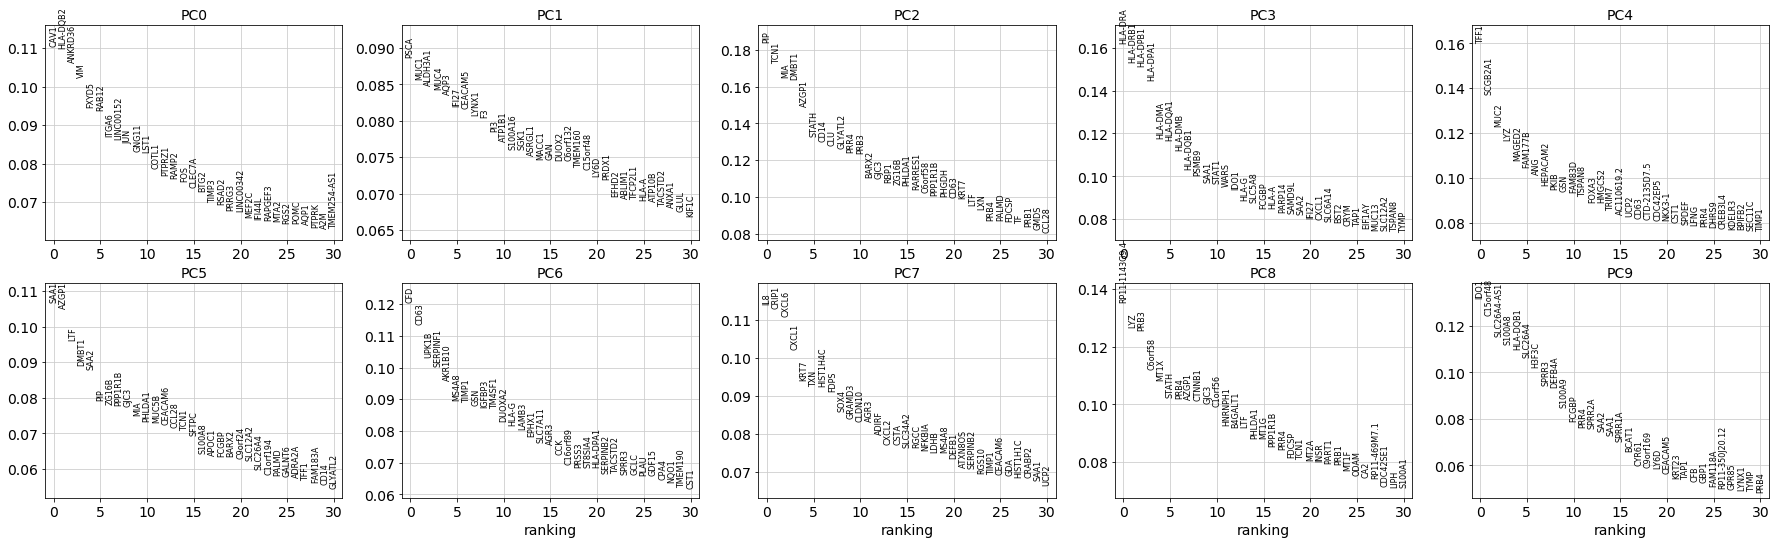

In [14]:
sc.pl.pca_loadings(adata, components=list(range(0,10)))

### Embedding

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=7)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished (0:00:06.35) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [16]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:11.48) --> added
    'X_umap', UMAP coordinates (adata.obsm)


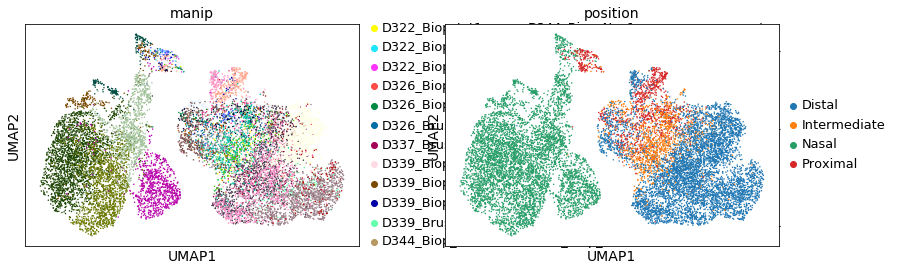

In [17]:
sc.pl.umap(adata, color=['manip', 'position'], edges = False)

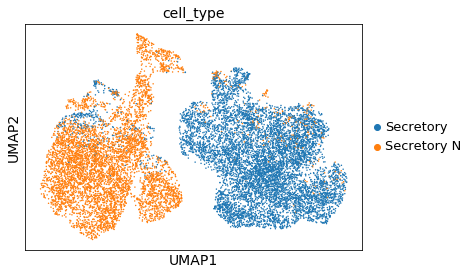

In [18]:
sc.pl.umap(adata, color=['cell_type'], edges = False)

## Clustering

In [27]:
communities, graph, Q = sc.external.tl.phenograph(adata.obsm['X_pca'][:,0:7], k=100)

PhenoGraph clustering
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.333794593811035 seconds
Jaccard graph constructed in 8.727689266204834 seconds
Wrote graph to binary file in 4.3553831577301025 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.823964
After 5 runs, maximum modularity is Q = 0.825429
Louvain completed 25 runs in 18.291626453399658 seconds
PhenoGraph complete in 33.84954309463501 seconds
    finished (0:00:34.26)


In [28]:
adata.obs['phenograph'] = pd.Categorical(communities)

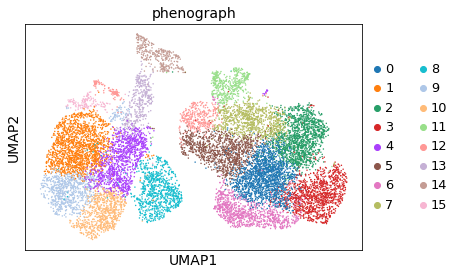

In [29]:
sc.pl.umap(adata, color=['phenograph'])

In [30]:
adata.raw = adata
mean_cellType = np.empty((len(adata.obs['phenograph'].unique()), adata.raw.shape[1]), 
                           dtype=float, order='C')
raw_adata = adata.raw.X

for i in range(0, len(adata.obs['phenograph'].unique())):
    #print(adata.obs['phenograph'].unique()[i])
    mean_cellType[i,:] = np.mean(raw_adata[adata.obs['phenograph'] == adata.obs['phenograph'].unique()[i], :], axis = 0)

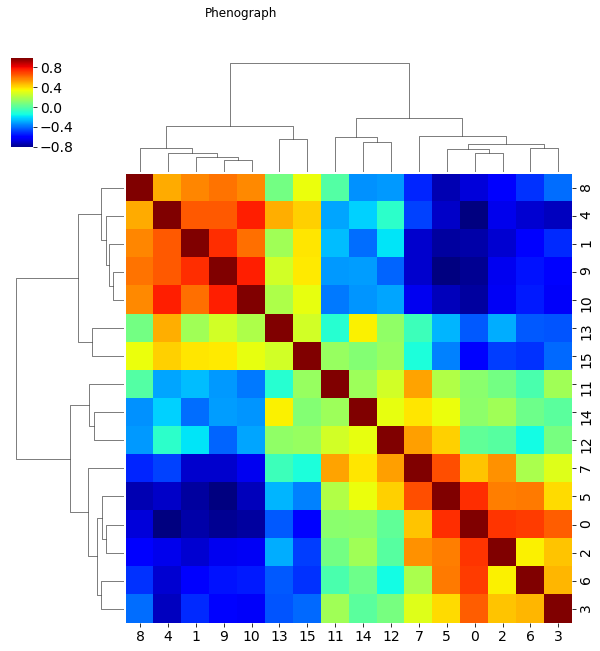

In [31]:
mean_df = pd.DataFrame(np.corrcoef(mean_cellType), index = adata.obs['phenograph'].unique(), columns = adata.obs['phenograph'].unique())

ax = seaborn.clustermap(mean_df, cmap="jet").fig.suptitle('Phenograph') 

In [32]:
sc.tl.rank_genes_groups(adata, groupby = 'phenograph', method='wilcoxon')

ranking genes
    finished (0:00:24.81) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


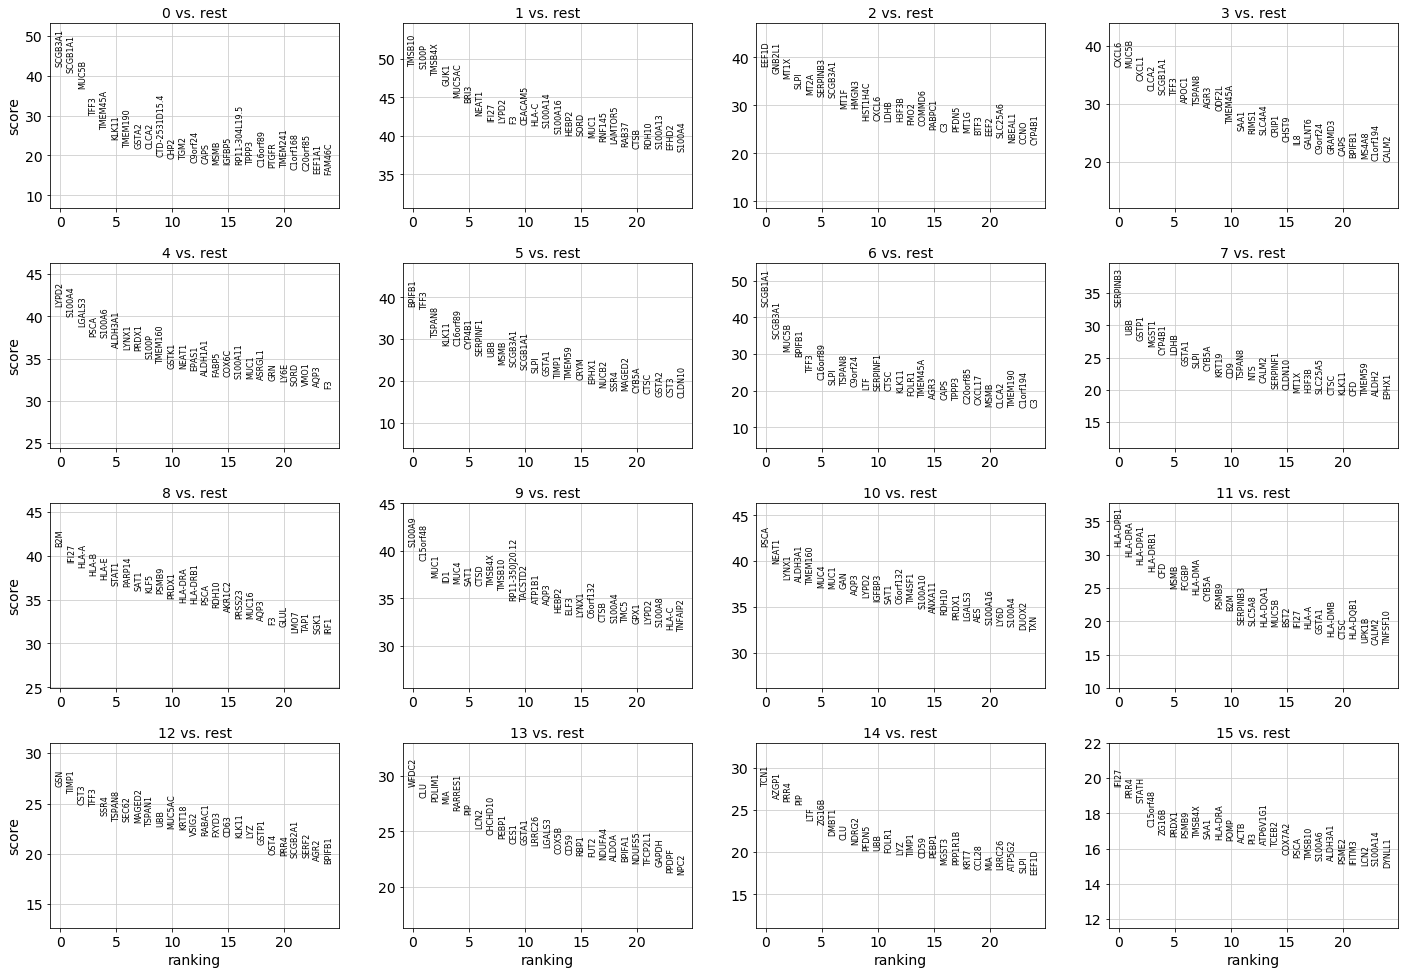

In [33]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

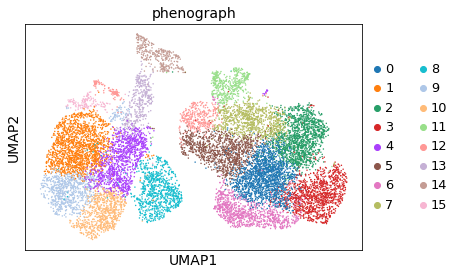

In [34]:
sc.pl.umap(adata, color=['phenograph'])

In [35]:
new_cluster_names = {
    '0':'Secretory', '1':'Secretory N', '2':'Secretory', '3':'Secretory', '4':'Secretory N', # 0-4
    '5':'Secretory','6':'Secretory', '7':'Secretory', '8':'Secretory N', '9':'Secretory N', '10':'Secretory N', # 5-9
    '11':'Secretory', '12':'Secretory', '13':'Secretory N', '14':'Serous',
    '15':'Secretory N'}


In [36]:
vect = []
for i in range(0, len(adata.obs['phenograph'])):
    vect = vect + [new_cluster_names[str(adata.obs['phenograph'][i])]]
    
adata.obs['cell_type_detail'] = vect

... storing 'cell_type_detail' as categorical


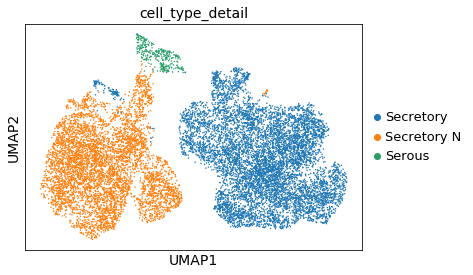

In [37]:
sc.pl.umap(adata, color=['cell_type_detail'])

***
*** 
# Re-define the boundaries of Secretory and Secretory N cells

In [38]:
## Associate final cell types
adata_ann.obs['cell_type_v2'] = adata_ann.obs.cell_type.astype('str')
adata_ann.obs.loc[adata.obs.index.tolist(), 'cell_type_v2'] = adata.obs['cell_type_detail']


... storing 'cell_type_v2' as categorical


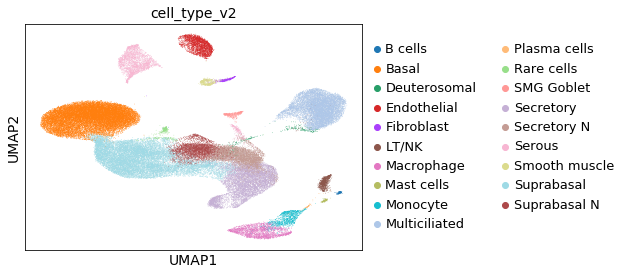

In [39]:
sc.pl.umap(adata_ann, color=['cell_type_v2'])

In [73]:
# Add annotation
adata = adata_raw[adata_ann.obs.index.tolist(), ]
adata.obs['cell_type_v2'] = adata_ann.obs['cell_type_v2']
adata.shape

(77969, 32568)

### Selection of the refined Secretory cells

In [74]:
immune_cell_bool = []

for x in adata.obs['cell_type_v2']:
    immune_cell_bool = immune_cell_bool + [x in ['Secretory']]


In [75]:
list_of_cell_names = adata.obs.loc[immune_cell_bool, :].index.tolist()
adata_sc = adata[list_of_cell_names, ]
adata_sc.shape

(8021, 32568)

In [76]:
# Remove unwanted genes (mitochondrial genes)
genes_names = adata_sc.var.index.tolist()
keep_genes = [i for i in genes_names if not i.startswith('MT-')]
adata_sc = adata_sc[:,keep_genes]

In [77]:
sc.pp.filter_genes(adata_sc, min_cells=100)
adata_sc.X.shape

filtered out 20286 genes that are detected in less than 100 cells


(8021, 12269)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


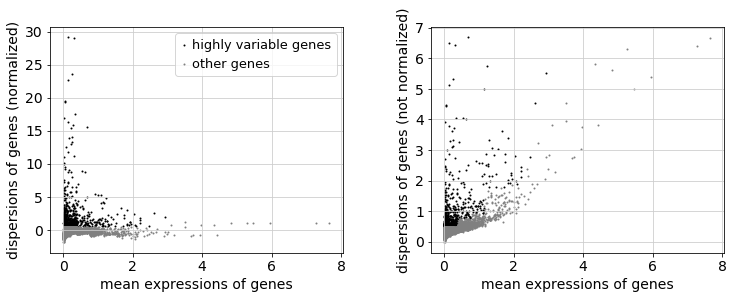

In [78]:
sc.pp.highly_variable_genes(adata_sc, min_mean=0.01, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_sc)

In [46]:
np.sum(adata_sc.var['highly_variable'])

1300

In [63]:
sc.pp.scale(adata_sc, max_value=10)

In [79]:
sc.tl.pca(adata_sc, svd_solver='arpack')

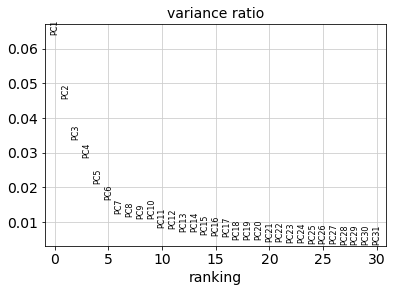

In [80]:
sc.pl.pca_variance_ratio(adata_sc, log = False)

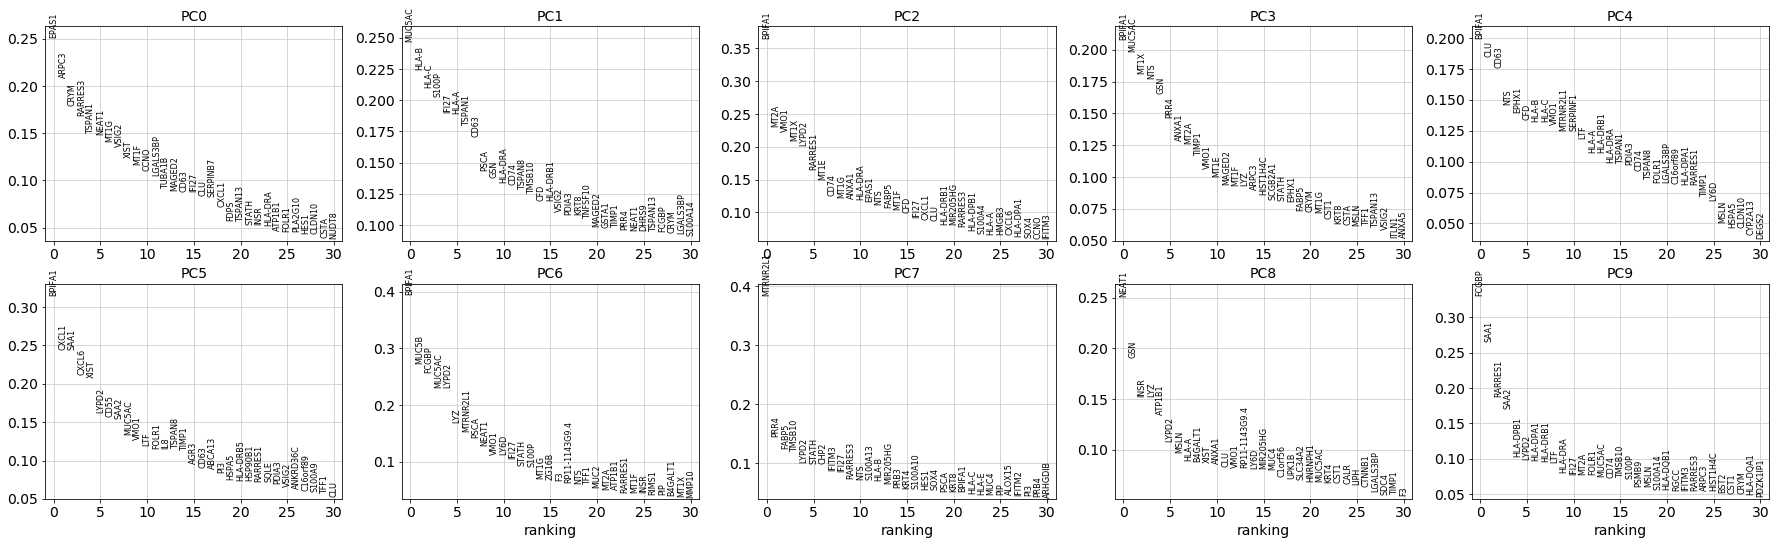

In [81]:
sc.pl.pca_loadings(adata_sc, components=list(range(0,10)))

In [90]:
sc.pp.neighbors(adata_sc, n_neighbors=10, n_pcs=7)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished (0:00:01.58) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [91]:
sc.tl.umap(adata_sc)

computing UMAP
    finished (0:00:15.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)


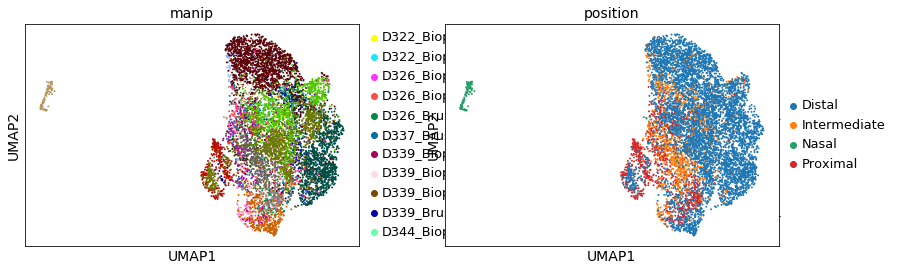

In [92]:
sc.pl.umap(adata_sc, color=['manip', 'position'], edges = False)

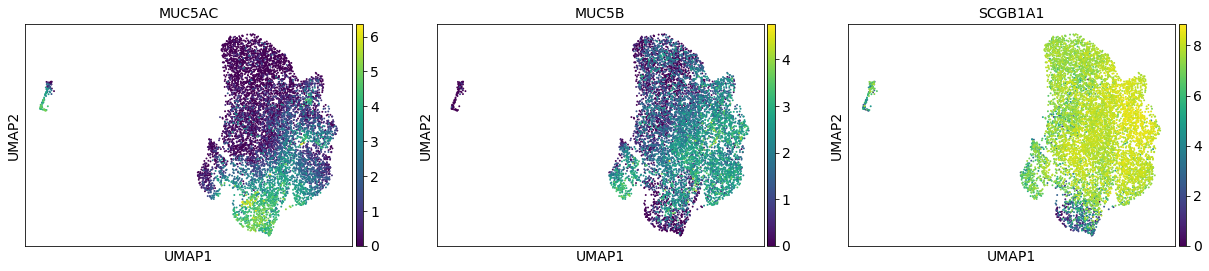

In [93]:
sc.pl.umap(adata_sc, color=['MUC5AC', 'MUC5B', 'SCGB1A1'])

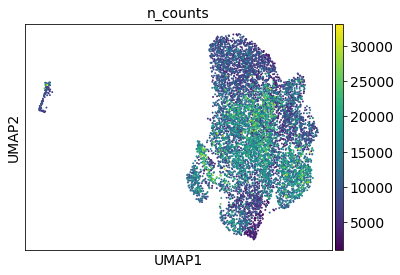

In [94]:
sc.pl.umap(adata_sc, color=['n_counts'])

In [95]:
communities, graph, Q = sc.external.tl.phenograph(adata_sc.obsm['X_pca'][:,0:7], k=100)

PhenoGraph clustering
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2154595851898193 seconds
Jaccard graph constructed in 4.925629377365112 seconds
Wrote graph to binary file in 2.737020492553711 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.765859
Louvain completed 21 runs in 6.4585371017456055 seconds
PhenoGraph complete in 15.42349123954773 seconds
    finished (0:00:15.63)


In [96]:
adata_sc.obs['phenograph'] = pd.Categorical(communities)

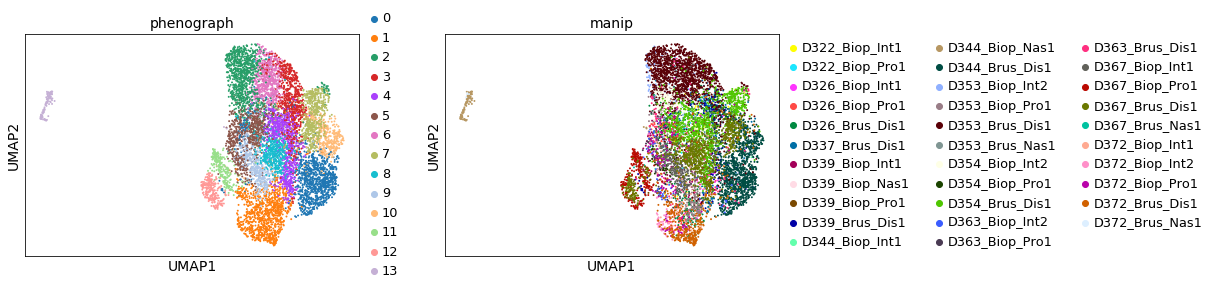

In [97]:
sc.pl.umap(adata_sc, color=['phenograph', 'manip'])

In [77]:
sc.tl.rank_genes_groups(adata_sc, groupby = 'phenograph', method='wilcoxon')

ranking genes
    finished (0:00:13.71) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


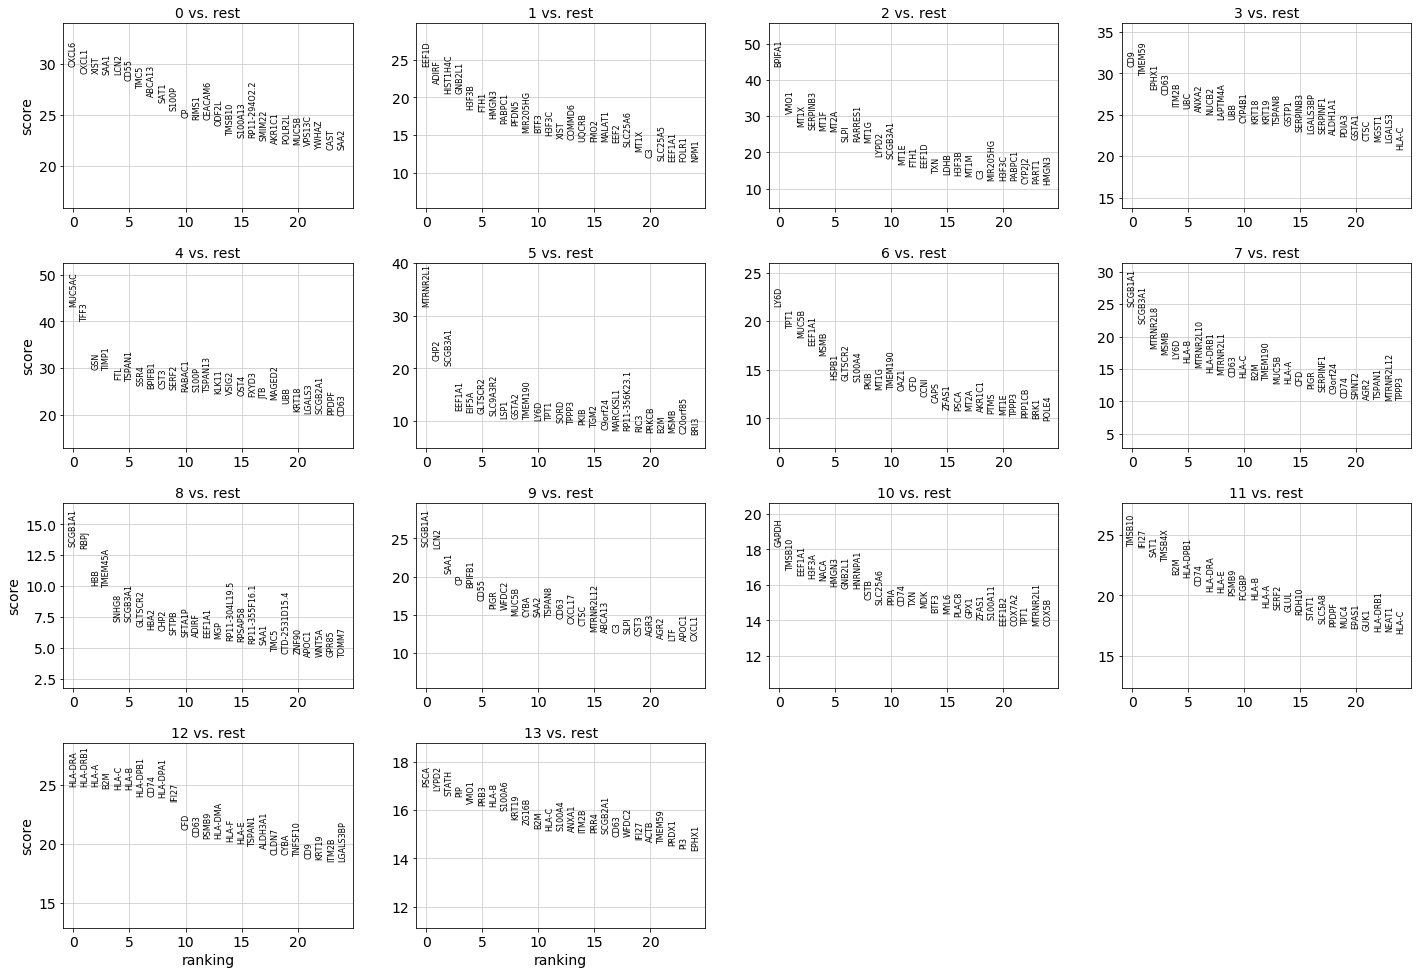

In [78]:
sc.pl.rank_genes_groups(adata_sc, n_genes=25, sharey=False)

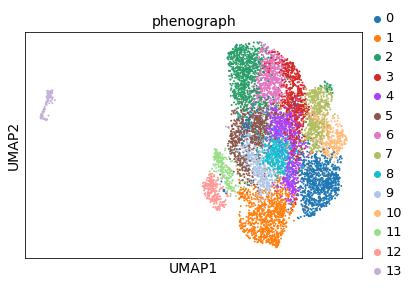

In [99]:
sc.pl.umap(adata_sc, color=['phenograph'])

In [100]:
new_cluster_names = {
    '0':'Secretory', '1':'Secretory', '2':'Secretory', '3':'Secretory', '4':'Secretory', # 0-4
    '5':'Secretory','6':'Secretory', '7':'Secretory', '8':'Secretory', '9':'Secretory', '10':'Secretory', # 5-9
    '11':'Secretory', '12':'Secretory', '13':'Secretory N'}


In [101]:
vect = []
for i in range(0, len(adata_sc.obs['phenograph'])):
    vect = vect + [new_cluster_names[str(adata_sc.obs['phenograph'][i])]]
    
adata_sc.obs['cell_type_detail'] = vect

... storing 'cell_type_detail' as categorical


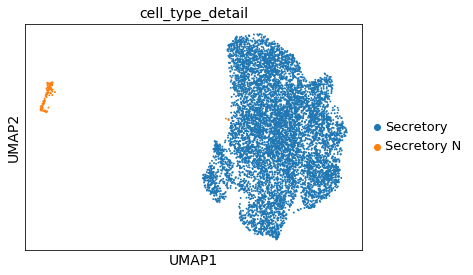

In [102]:
sc.pl.umap(adata_sc, color=['cell_type_detail'])

***
### Re-refining of the Secretory cell type labelling

In [103]:
## Associate final cell types
adata_ann.obs['cell_type_v2'] = adata_ann.obs.cell_type_v2.astype('str')
adata_ann.obs.loc[adata_sc.obs.index.tolist(), 'cell_type_v2'] = adata_sc.obs['cell_type_detail']


... storing 'cell_type_v2' as categorical


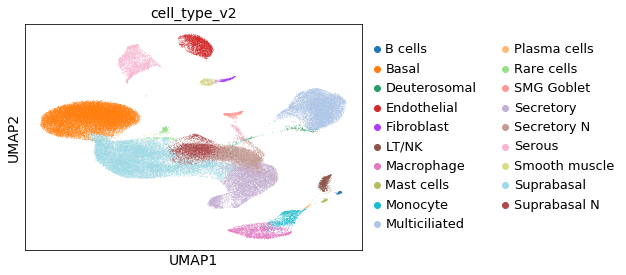

In [104]:
sc.pl.umap(adata_ann, color=['cell_type_v2'])

In [105]:
# Add annotation
adata = adata_raw[adata_ann.obs.index.tolist(), ]
adata.obs['cell_type_v2'] = adata_ann.obs['cell_type_v2']
adata.shape

(77969, 32568)

In [106]:
immune_cell_bool = []

for x in adata.obs['cell_type_v2']:
    immune_cell_bool = immune_cell_bool + [x in ['Secretory']]


In [141]:
list_of_cell_names = adata.obs.loc[immune_cell_bool, :].index.tolist()
adata_sc = adata_raw[list_of_cell_names, ]
adata_sc.shape

(7923, 32568)

In [142]:
adata_sc.raw = adata_sc

In [143]:
# Remove unwanted genes (mitochondrial genes)
genes_names = adata_sc.var.index.tolist()
keep_genes = [i for i in genes_names if not i.startswith('MT-')]
adata_sc = adata_sc[:,keep_genes]

In [144]:
sc.pp.filter_genes(adata_sc, min_cells=100)
adata_sc.X.shape

filtered out 20328 genes that are detected in less than 100 cells


(7923, 12227)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


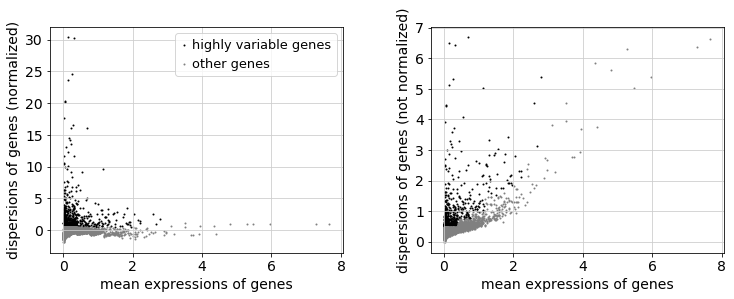

In [145]:
sc.pp.highly_variable_genes(adata_sc, min_mean=0.01, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_sc)

In [146]:
np.sum(adata_sc.var['highly_variable'])

1386

In [147]:
sc.pp.scale(adata_sc, max_value=10)

In [148]:
sc.tl.pca(adata_sc, svd_solver='arpack')

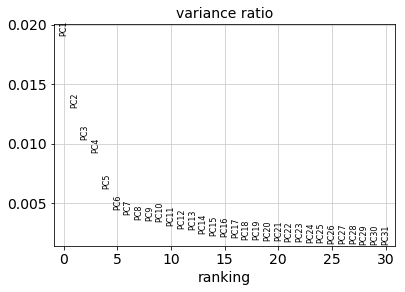

In [149]:
sc.pl.pca_variance_ratio(adata_sc, log = False)

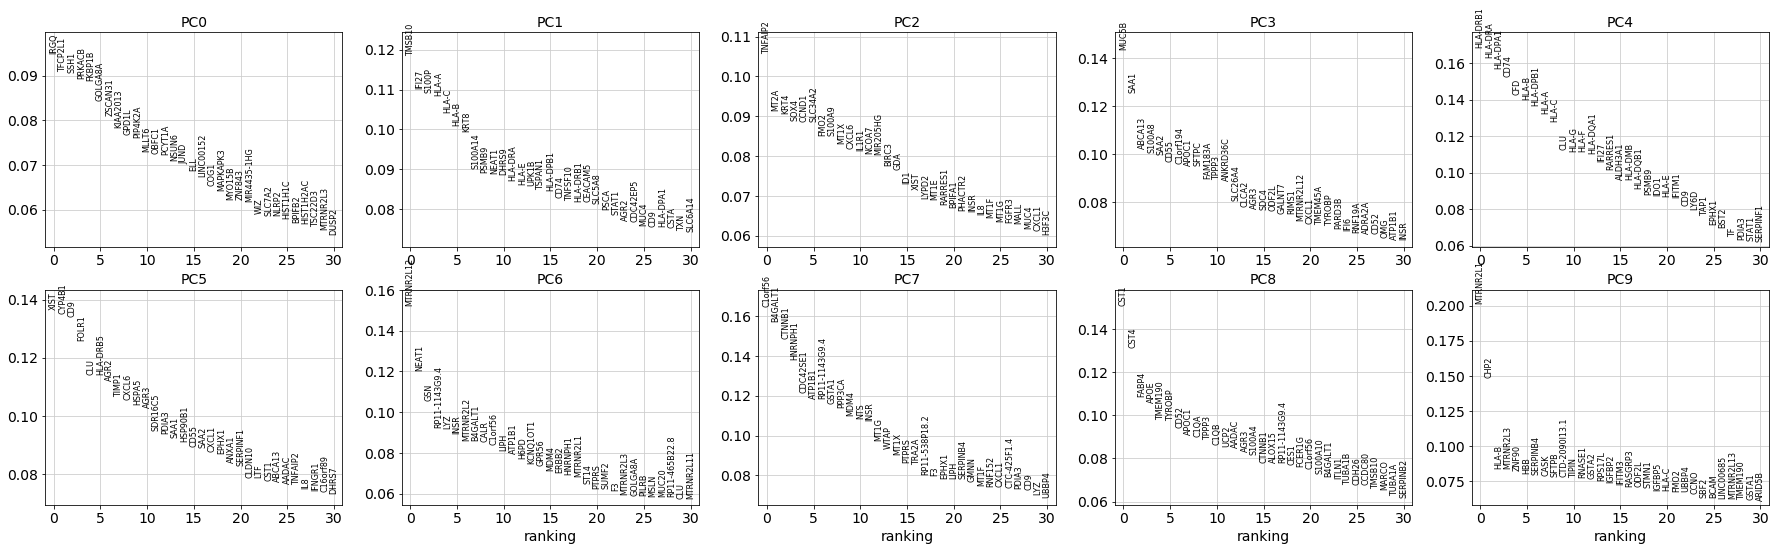

In [150]:
sc.pl.pca_loadings(adata_sc, components=list(range(0,10)))

In [151]:
sc.pp.neighbors(adata_sc, n_neighbors=100, n_pcs=4)

computing neighbors
    using 'X_pca' with n_pcs = 4
    finished (0:00:07.84) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [152]:
sc.tl.umap(adata_sc)

computing UMAP
    finished (0:00:32.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)


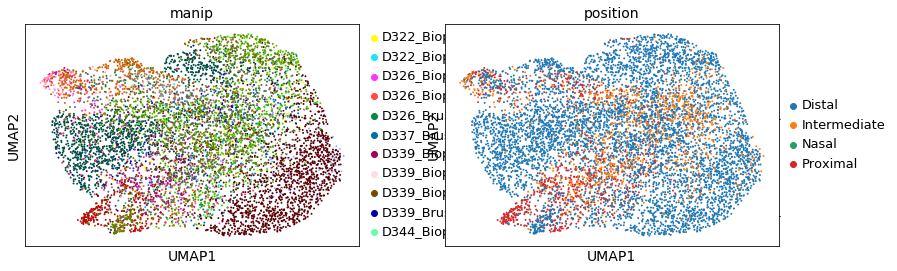

In [153]:
sc.pl.umap(adata_sc, color=['manip', 'position'], edges = False)

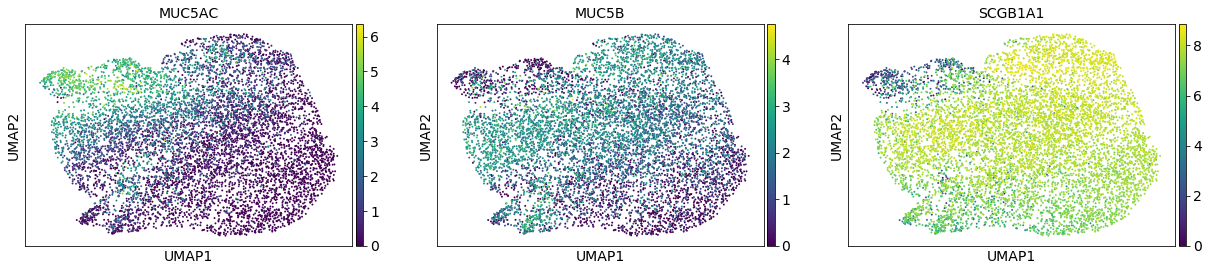

In [154]:
sc.pl.umap(adata_sc, color=['MUC5AC', 'MUC5B', 'SCGB1A1'])

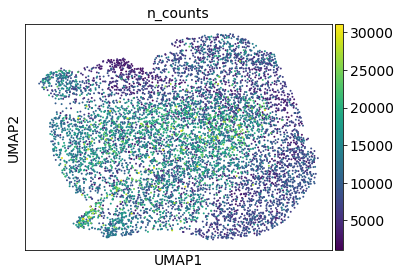

In [158]:
sc.pl.umap(adata_sc, color=['n_counts'])

In [155]:
communities, graph, Q = sc.external.tl.phenograph(adata_sc.obsm['X_pca'][:,0:4], k=100)

PhenoGraph clustering
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4226243495941162 seconds
Jaccard graph constructed in 4.812374114990234 seconds
Wrote graph to binary file in 2.568627119064331 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.763235
After 3 runs, maximum modularity is Q = 0.764745
After 5 runs, maximum modularity is Q = 0.766351
After 8 runs, maximum modularity is Q = 0.767709
Louvain completed 28 runs in 10.248286962509155 seconds
PhenoGraph complete in 18.150002479553223 seconds
    finished (0:00:18.35)


In [156]:
adata_sc.obs['phenograph'] = pd.Categorical(communities)

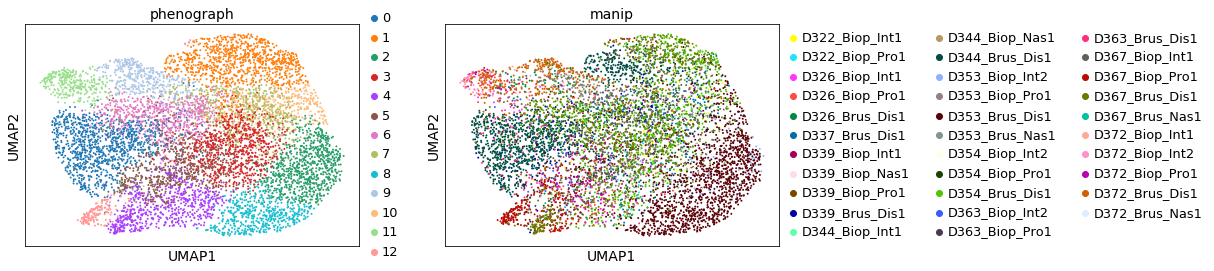

In [157]:
sc.pl.umap(adata_sc, color=['phenograph', 'manip'])

In [159]:
sc.tl.rank_genes_groups(adata_sc, groupby = 'phenograph', method='wilcoxon')

ranking genes
    finished (0:00:20.92) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


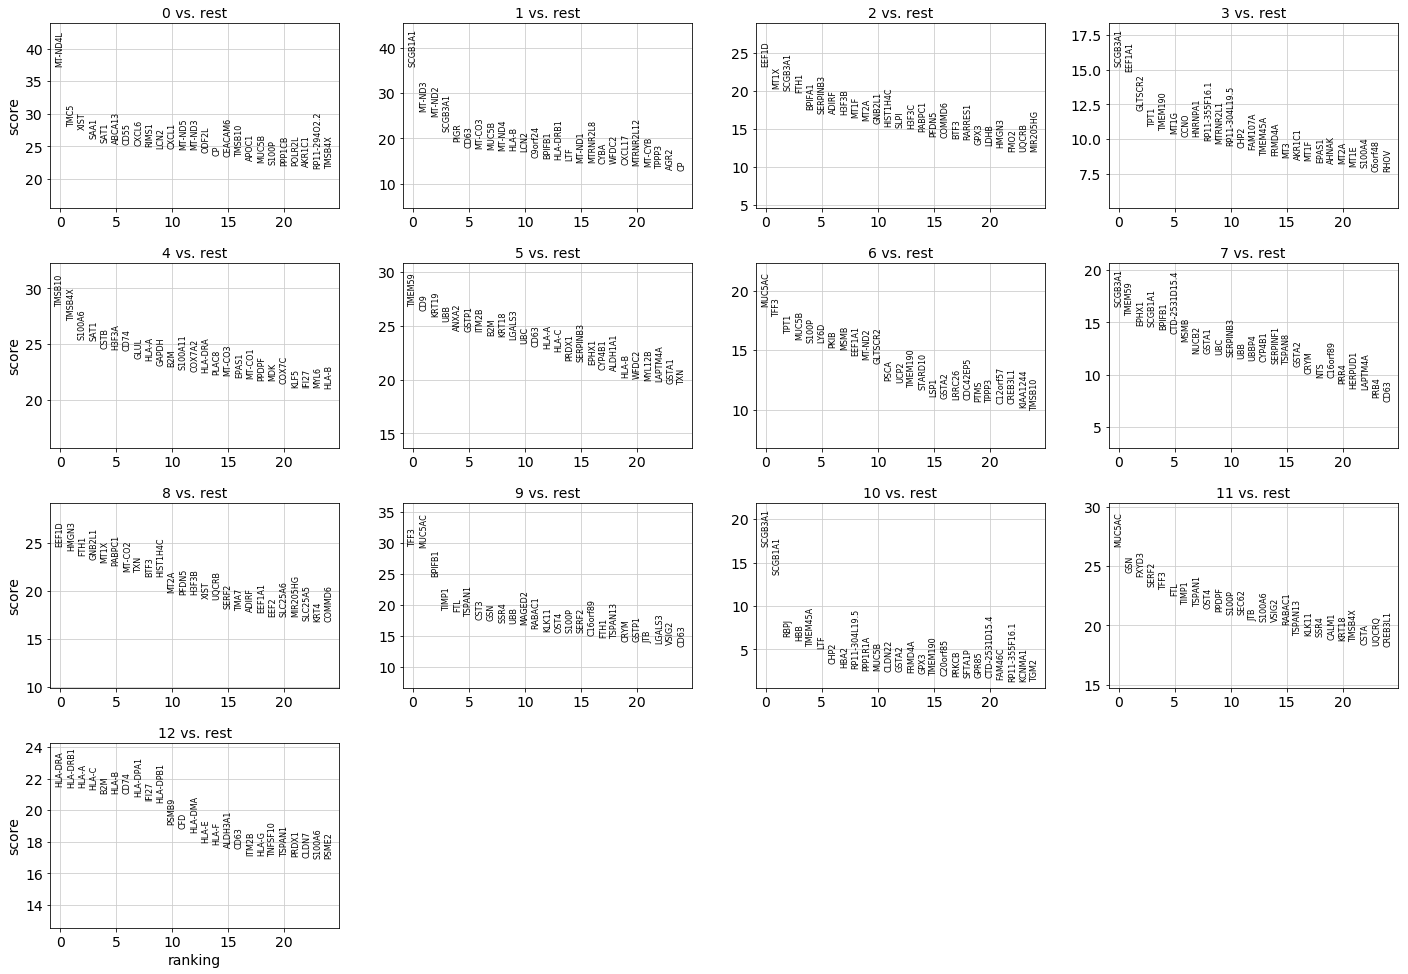

In [160]:
sc.pl.rank_genes_groups(adata_sc, n_genes=25, sharey=False)

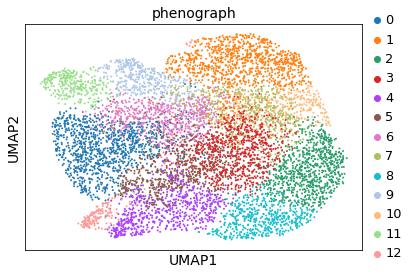

In [161]:
sc.pl.umap(adata_sc, color=['phenograph'])

In [167]:
new_cluster_names = {
    '0':'Secretory', '1':'Secretory', '2':'Club', '3':'Club', '4':'Club', # 0-4
    '5':'Club','6':'Secretory', '7':'Club', '8':'Club', '9':'Goblet', '10':'Club', # 5-9
    '11':'Goblet', '12':'Club'}


In [168]:
vect = []
for i in range(0, len(adata_sc.obs['phenograph'])):
    vect = vect + [new_cluster_names[str(adata_sc.obs['phenograph'][i])]]
    
adata_sc.obs['cell_type_detail'] = vect

... storing 'cell_type_detail' as categorical


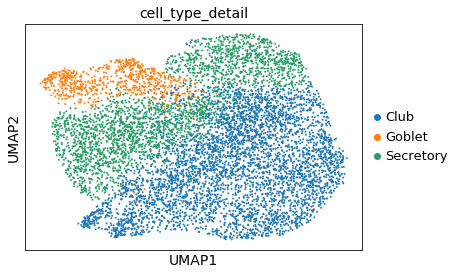

In [169]:
sc.pl.umap(adata_sc, color=['cell_type_detail'])

In [170]:
sc.tl.rank_genes_groups(adata_sc, groupby = 'cell_type_detail', method='wilcoxon')

ranking genes
    finished (0:00:16.75) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


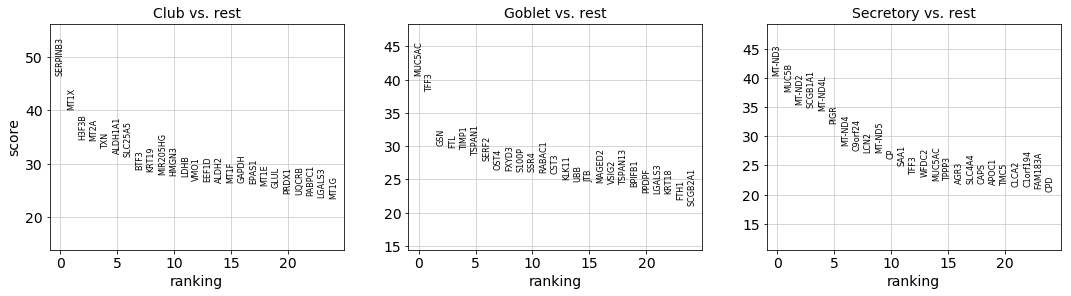

In [171]:
sc.pl.rank_genes_groups(adata_sc, n_genes=25, sharey=False)

***
*** 
# Refining of the Secretory N cells

In [172]:
## Associate final cell types
adata_ann.obs['cell_type_v2'] = adata_ann.obs.cell_type_v2.astype('str')
adata_ann.obs.loc[adata_sc.obs.index.tolist(), 'cell_type_v2'] = adata_sc.obs['cell_type_detail']


... storing 'cell_type_v2' as categorical


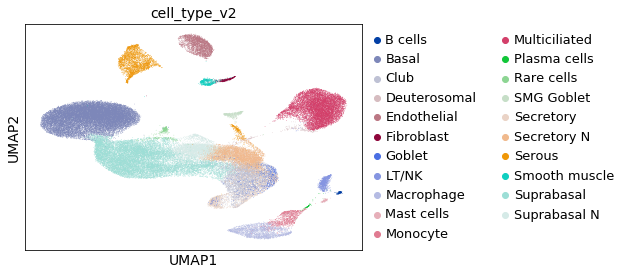

In [173]:
sc.pl.umap(adata_ann, color=['cell_type_v2'])

In [174]:
# Add annotation
adata = adata_raw[adata_ann.obs.index.tolist(), ]
adata.obs['cell_type_v2'] = adata_ann.obs['cell_type_v2']
adata.shape

(77969, 32568)

In [190]:
immune_cell_bool = []

for x in adata.obs['cell_type_v2']:
    immune_cell_bool = immune_cell_bool + [x in ['Secretory N']]


In [191]:
list_of_cell_names = adata.obs.loc[immune_cell_bool, :].index.tolist()
adata_sc = adata_raw[list_of_cell_names, ]
adata_sc.shape

(5732, 32568)

In [192]:
adata_sc.raw = adata_sc

In [193]:
# Remove unwanted genes (mitochondrial genes)
genes_names = adata_sc.var.index.tolist()
keep_genes = [i for i in genes_names if not i.startswith('MT-')]
adata_sc = adata_sc[:,keep_genes]

In [194]:
sc.pp.filter_genes(adata_sc, min_cells=100)
adata_sc.X.shape

filtered out 19778 genes that are detected in less than 100 cells


(5732, 12777)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


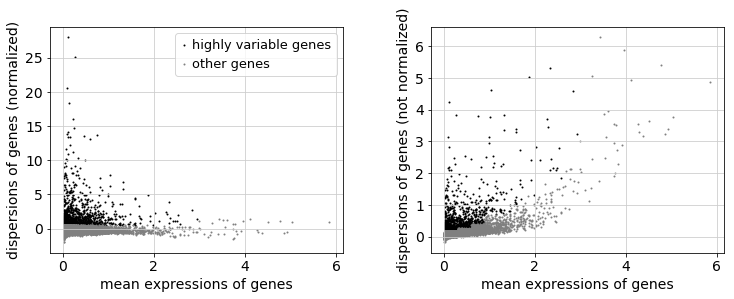

In [195]:
sc.pp.highly_variable_genes(adata_sc, min_mean=0.01, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_sc)

In [196]:
np.sum(adata_sc.var['highly_variable'])

1434

In [197]:
sc.pp.scale(adata_sc, max_value=10)

In [198]:
sc.tl.pca(adata_sc, svd_solver='arpack')

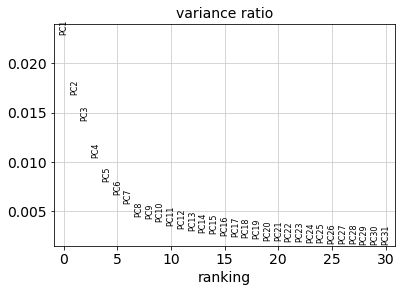

In [199]:
sc.pl.pca_variance_ratio(adata_sc, log = False)

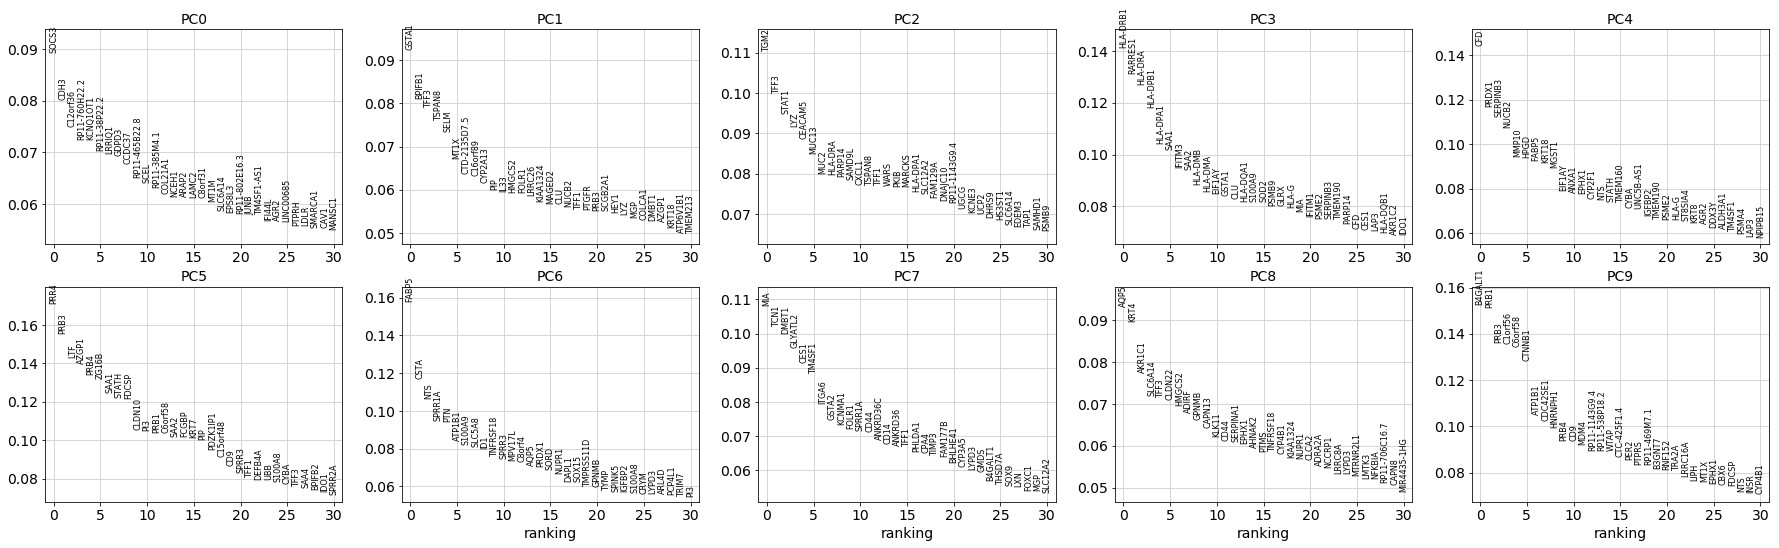

In [200]:
sc.pl.pca_loadings(adata_sc, components=list(range(0,10)))

In [205]:
sc.pp.neighbors(adata_sc, n_neighbors=100, n_pcs=3)

computing neighbors
    using 'X_pca' with n_pcs = 3
    finished (0:00:05.52) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [206]:
sc.tl.umap(adata_sc)

computing UMAP
    finished (0:00:22.92) --> added
    'X_umap', UMAP coordinates (adata.obsm)


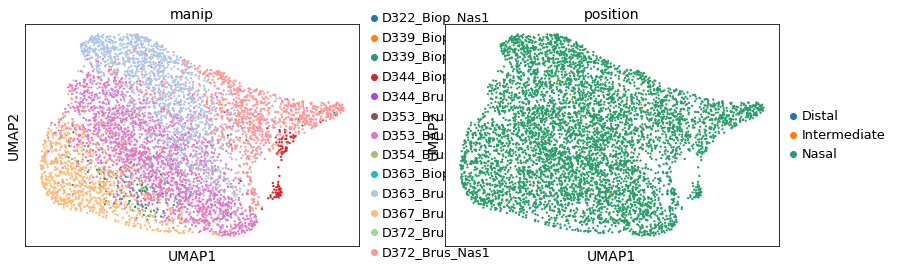

In [207]:
sc.pl.umap(adata_sc, color=['manip', 'position'], edges = False)

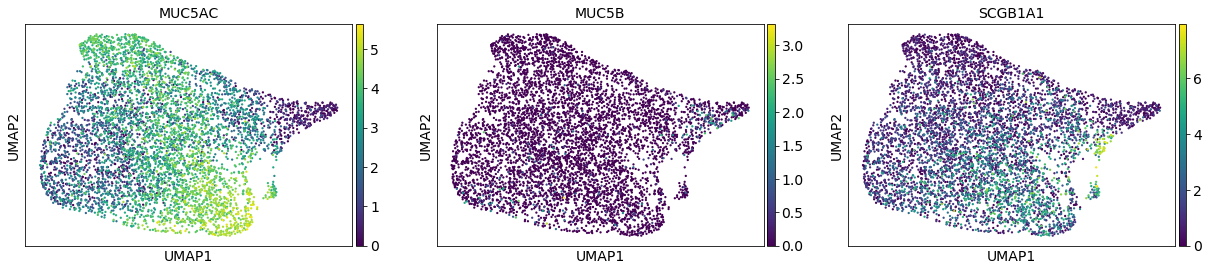

In [208]:
sc.pl.umap(adata_sc, color=['MUC5AC', 'MUC5B', 'SCGB1A1'])

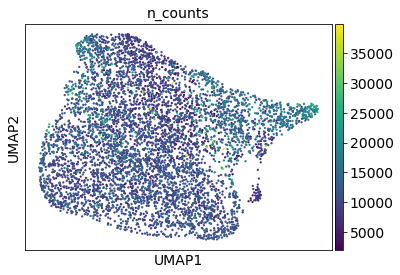

In [209]:
sc.pl.umap(adata_sc, color=['n_counts'])

In [210]:
communities, graph, Q = sc.external.tl.phenograph(adata_sc.obsm['X_pca'][:,0:3], k=100)

PhenoGraph clustering
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22139644622802734 seconds
Jaccard graph constructed in 3.8756000995635986 seconds
Wrote graph to binary file in 2.1153483390808105 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.745886
After 2 runs, maximum modularity is Q = 0.747137
After 11 runs, maximum modularity is Q = 0.748145
After 13 runs, maximum modularity is Q = 0.749195
Louvain completed 33 runs in 8.860906839370728 seconds
PhenoGraph complete in 15.14586877822876 seconds
    finished (0:00:15.27)


In [211]:
adata_sc.obs['phenograph'] = pd.Categorical(communities)

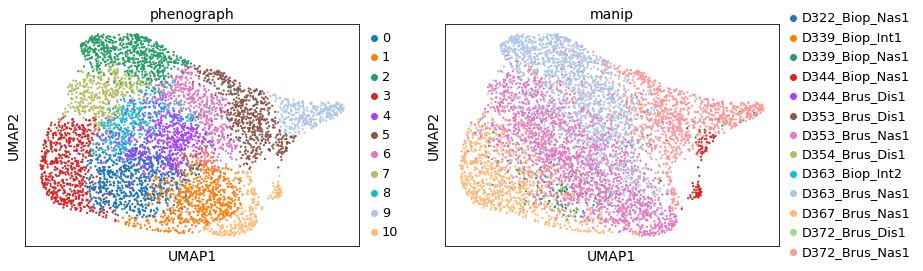

In [212]:
sc.pl.umap(adata_sc, color=['phenograph', 'manip'])

In [213]:
sc.tl.rank_genes_groups(adata_sc, groupby = 'phenograph', method='wilcoxon')

ranking genes
    finished (0:00:17.45) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


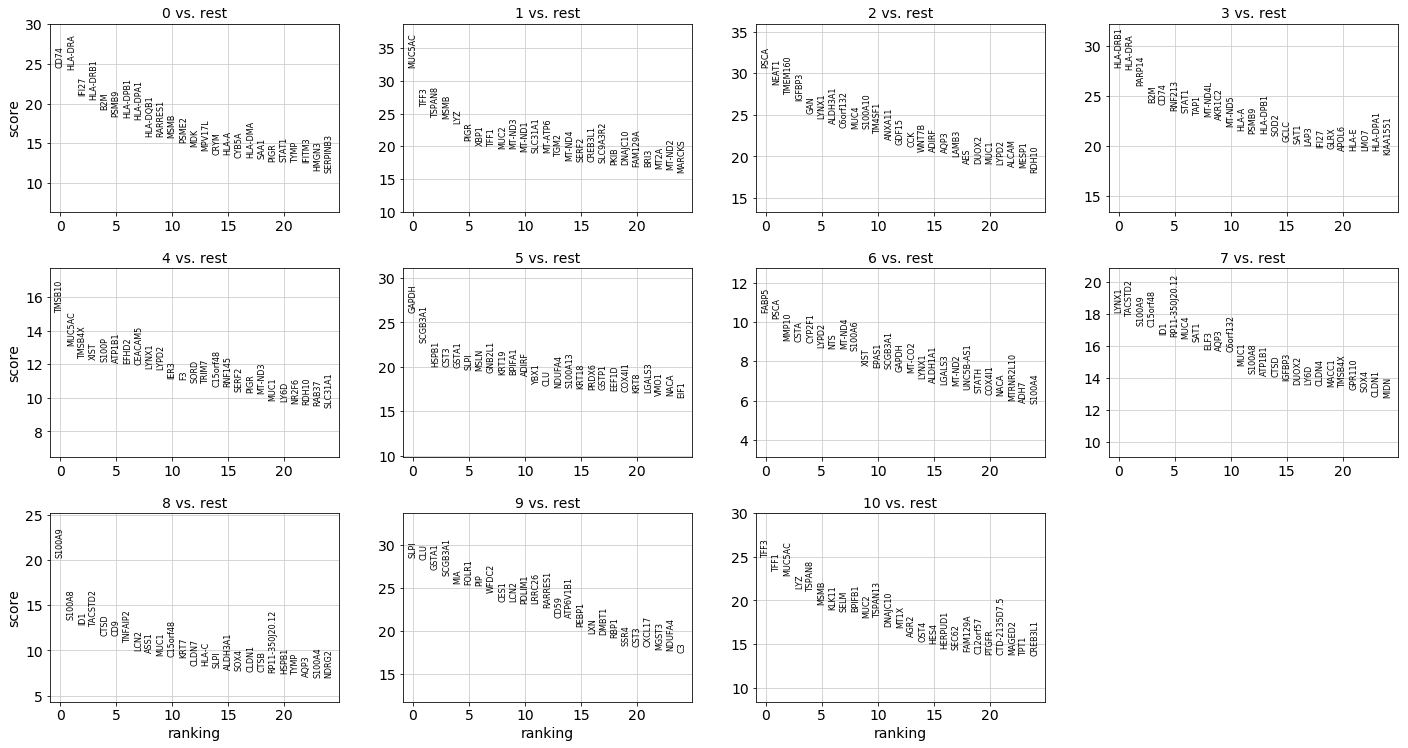

In [214]:
sc.pl.rank_genes_groups(adata_sc, n_genes=25, sharey=False)

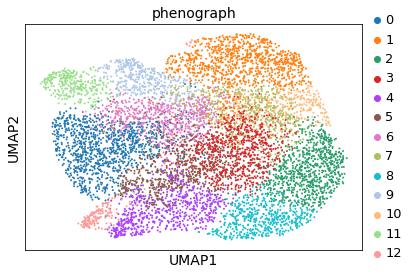

In [161]:
sc.pl.umap(adata_sc, color=['phenograph'])

In [167]:
new_cluster_names = {
    '0':'Secretory', '1':'Secretory', '2':'Club', '3':'Club', '4':'Club', # 0-4
    '5':'Club','6':'Secretory', '7':'Club', '8':'Club', '9':'Goblet', '10':'Club', # 5-9
    '11':'Goblet', '12':'Club'}


In [168]:
vect = []
for i in range(0, len(adata_sc.obs['phenograph'])):
    vect = vect + [new_cluster_names[str(adata_sc.obs['phenograph'][i])]]
    
adata_sc.obs['cell_type_detail'] = vect

... storing 'cell_type_detail' as categorical


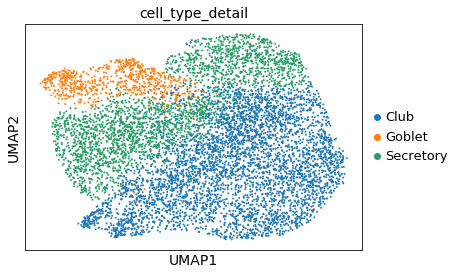

In [169]:
sc.pl.umap(adata_sc, color=['cell_type_detail'])

In [170]:
sc.tl.rank_genes_groups(adata_sc, groupby = 'cell_type_detail', method='wilcoxon')

ranking genes
    finished (0:00:16.75) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


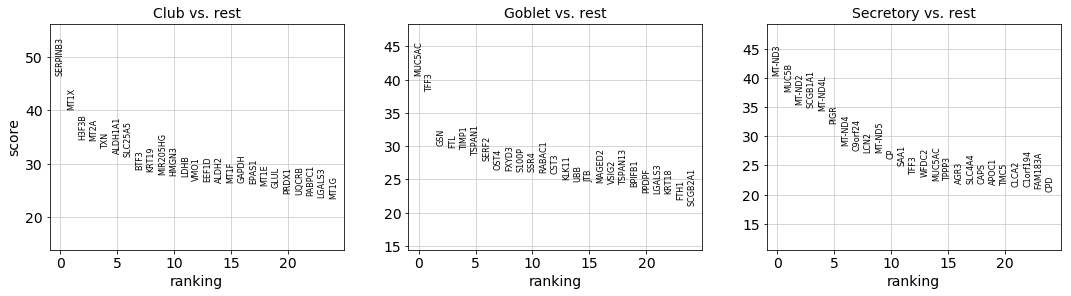

In [171]:
sc.pl.rank_genes_groups(adata_sc, n_genes=25, sharey=False)